In [6]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from catboost import CatBoostRegressor


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error


# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
pd.set_option('display.max_columns', None)

In [8]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [9]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions, y_test = m_wrap.get_test(aggregated=True)
predictions['pv_measurement'] = y_test



In [40]:
y_test.describe()

count    4229.000000
mean      653.280092
std      1131.785084
min         0.000000
25%         6.900000
50%       200.962500
75%       682.000000
max      5733.420000
Name: pv_measurement, dtype: float64

In [39]:
y_train_agg[X_train_agg['date_forecast'].between('2020-05-01','2020-07-01')].describe()

count    4320.000000
mean      624.205176
std      1066.404152
min         0.000000
25%         9.295000
50%       209.587500
75%       685.687500
max      5448.740000
Name: pv_measurement, dtype: float64

<Axes: xlabel='date_forecast', ylabel='pv_measurement'>

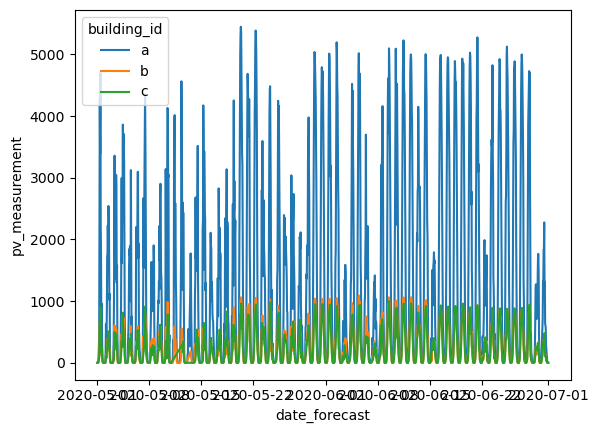

In [38]:
X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=False)


sns.lineplot(x=X_train_agg[X_train_agg['date_forecast'].between('2020-05-01','2020-07-01')]['date_forecast'],y=y_train_agg[X_train_agg['date_forecast'].between('2020-05-01','2020-07-01')],hue=X_train_agg['building_id'])


<Axes: xlabel='date_forecast', ylabel='pv_measurement'>

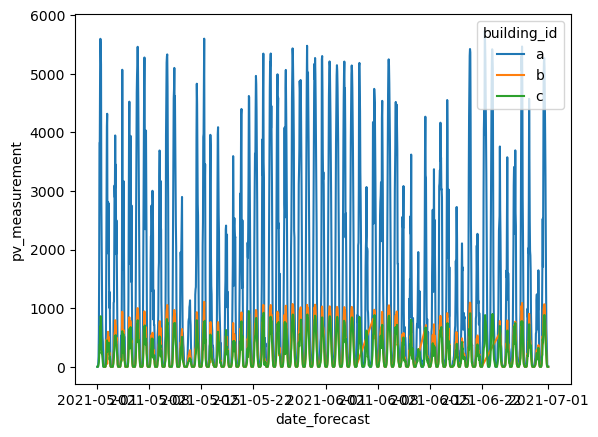

In [35]:
sns.lineplot(x=predictions['date_forecast'],y=y_test,hue=predictions['building_id'])

# Model 1

In [10]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_test_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=1500,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_test_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_test_agg))

    predictions[f'{name}_{i}'] = pred_sub

0:	learn: 0.1476002	total: 120ms	remaining: 2m 59s
1:	learn: 0.1438398	total: 237ms	remaining: 2m 57s
2:	learn: 0.1399340	total: 354ms	remaining: 2m 56s
3:	learn: 0.1361832	total: 472ms	remaining: 2m 56s
4:	learn: 0.1326156	total: 583ms	remaining: 2m 54s
5:	learn: 0.1293522	total: 701ms	remaining: 2m 54s
6:	learn: 0.1259468	total: 815ms	remaining: 2m 53s
7:	learn: 0.1227149	total: 931ms	remaining: 2m 53s
8:	learn: 0.1195749	total: 1.04s	remaining: 2m 53s
9:	learn: 0.1165760	total: 1.16s	remaining: 2m 52s
10:	learn: 0.1135913	total: 1.28s	remaining: 2m 52s
11:	learn: 0.1109276	total: 1.39s	remaining: 2m 52s
12:	learn: 0.1081983	total: 1.52s	remaining: 2m 53s
13:	learn: 0.1055685	total: 1.64s	remaining: 2m 54s
14:	learn: 0.1031909	total: 1.77s	remaining: 2m 55s
15:	learn: 0.1009061	total: 1.9s	remaining: 2m 56s
16:	learn: 0.0986196	total: 2.03s	remaining: 2m 56s
17:	learn: 0.0963782	total: 2.15s	remaining: 2m 57s
18:	learn: 0.0942541	total: 2.27s	remaining: 2m 57s
19:	learn: 0.0922388	to

In [11]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_test_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=1500,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_test_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_test_agg))

    predictions[f'{name}_{i}'] = pred_sub

0:	learn: 0.1474972	total: 142ms	remaining: 3m 32s
1:	learn: 0.1435391	total: 260ms	remaining: 3m 15s
2:	learn: 0.1396985	total: 347ms	remaining: 2m 53s
3:	learn: 0.1360247	total: 465ms	remaining: 2m 53s
4:	learn: 0.1324530	total: 582ms	remaining: 2m 53s
5:	learn: 0.1291836	total: 705ms	remaining: 2m 55s
6:	learn: 0.1258126	total: 822ms	remaining: 2m 55s
7:	learn: 0.1226473	total: 986ms	remaining: 3m 3s
8:	learn: 0.1197250	total: 1.13s	remaining: 3m 6s
9:	learn: 0.1165995	total: 1.28s	remaining: 3m 10s
10:	learn: 0.1137685	total: 1.51s	remaining: 3m 23s
11:	learn: 0.1109886	total: 1.66s	remaining: 3m 25s
12:	learn: 0.1083164	total: 1.97s	remaining: 3m 45s
13:	learn: 0.1058547	total: 2.17s	remaining: 3m 49s
14:	learn: 0.1033856	total: 2.53s	remaining: 4m 10s
15:	learn: 0.1010021	total: 2.85s	remaining: 4m 24s
16:	learn: 0.0988748	total: 3.27s	remaining: 4m 44s
17:	learn: 0.0966786	total: 3.45s	remaining: 4m 43s
18:	learn: 0.0945813	total: 3.6s	remaining: 4m 40s
19:	learn: 0.0925947	tota

In [12]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_test_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=1500,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_test_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_test_agg))

    predictions[f'{name}_{i}'] = pred_sub

0:	learn: 0.1477738	total: 425ms	remaining: 10m 36s
1:	learn: 0.1438579	total: 839ms	remaining: 10m 28s
2:	learn: 0.1400316	total: 1.26s	remaining: 10m 29s
3:	learn: 0.1363844	total: 1.71s	remaining: 10m 38s
4:	learn: 0.1328688	total: 2.41s	remaining: 12m 1s
5:	learn: 0.1293630	total: 3.19s	remaining: 13m 13s
6:	learn: 0.1260797	total: 3.62s	remaining: 12m 52s
7:	learn: 0.1229202	total: 4.06s	remaining: 12m 37s
8:	learn: 0.1198127	total: 4.49s	remaining: 12m 23s
9:	learn: 0.1169681	total: 4.91s	remaining: 12m 12s
10:	learn: 0.1139925	total: 5.32s	remaining: 12m
11:	learn: 0.1113124	total: 5.74s	remaining: 11m 51s
12:	learn: 0.1086967	total: 6.16s	remaining: 11m 44s
13:	learn: 0.1060973	total: 6.57s	remaining: 11m 37s
14:	learn: 0.1035877	total: 6.99s	remaining: 11m 31s
15:	learn: 0.1011898	total: 7.4s	remaining: 11m 26s
16:	learn: 0.0988532	total: 7.86s	remaining: 11m 25s
17:	learn: 0.0966109	total: 8.27s	remaining: 11m 21s
18:	learn: 0.0944298	total: 8.69s	remaining: 11m 17s
19:	learn

In [13]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_date_calc,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,mean_effective_cloud_cover:p_-1h,mean_effective_cloud_cover:p_1h,mean_cloud_base_agl:m_-1h,mean_cloud_base_agl:m_1h,pv_measurement,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3
0,a,2021-05-01 00:00:00,0,0.0,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.750,1.28800,2263.399902,0.000000,0.000000,383.899994,0.00,272.850006,0.000000,0.000000,0.000,0.000000,80.099998,0.00,1.0,1016.575012,0.0,0.0,1003.450012,1009.724976,0.0,0.0,86.250000,1016.025024,15.557000,-10.45100,0.05,274.100006,80.175003,16891.125000,1.900,1.850,0.400,0.0,NaT,0.000000,1.359342,0.000000,163.937500,0.000000,0.977416,0.209815,0.000000,1.000000,189.842712,206.237961,81.43250,0.000000,0.000000,0.000000,0.000000,92.400002,73.224998,388.250000,448.549988,0.00,1.339009,1.574010,-3.945409,-0.063974,0.033286,0.365537,0.030146,-0.041379,2.171025,-7.779046,0.786840,-0.143654
1,a,2021-05-01 01:00:00,0,0.0,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.600,1.28750,1671.375000,0.000000,0.000000,388.250000,0.00,272.549988,0.000000,0.000000,0.000,0.000000,92.400002,0.00,1.0,1016.825012,0.0,0.0,1003.599976,1009.900024,0.0,0.0,85.599998,1016.200012,30.024000,-7.85575,0.10,273.924988,92.425003,17319.949219,1.625,1.600,0.300,0.0,NaT,0.000000,1.385789,0.000000,139.107513,0.000000,0.982041,0.183787,0.258819,0.965926,189.842712,206.237961,87.65875,0.000000,0.000000,0.000000,0.000000,98.125000,80.099998,347.475006,383.899994,0.00,-8.489839,4.471349,6.101910,30.544830,0.153468,-3.564781,-1.579268,1.149747,-2.384826,6.875776,-3.919289,1.902829
2,a,2021-05-01 02:00:00,0,0.0,2021-05-01 02:00:00,2021-05-01,2021-05,5,2,4.650,1.28575,1051.675049,0.000000,0.000000,347.475006,0.00,272.649994,0.000000,0.000000,0.000,0.000000,98.125000,0.00,1.0,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,86.800003,1016.200012,44.045750,-3.82025,0.10,273.799988,98.125000,16589.625000,1.675,1.600,0.425,0.0,NaT,0.000000,1.311341,0.000000,145.372498,0.000000,0.966227,0.256470,0.500000,0.866025,189.842712,206.237961,92.87750,4.125000,0.000000,1129.012451,0.000000,98.125000,92.400002,323.350006,388.250000,0.00,-4.254780,-8.852324,-0.341608,-4.424601,1.089323,-0.474493,-9.012270,1.944267,0.238961,1.083758,-1.260887,-2.371939
3,a,2021-05-01 03:00:00,0,0.0,2021-05-01 03:00:00,2021-05-01,2021-05,5,3,4.750,1.28475,1624.300049,9835.325195,11.400000,323.350006,0.00,272.950012,3.975000,7132.049805,0.150,282.500000,98.125000,0.75,0.5,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,88.349998,1016.200012,57.613750,1.37325,0.20,273.700012,98.125000,14928.175781,1.525,1.450,0.400,0.0,NaT,4.125000,1.300201,1129.012451,134.707504,11.096075,0.963420,0.267251,0.707107,0.707107,189.842712,206.237961,96.85250,23.049999,0.000000,6308.427734,0.000000,98.824997,98.1250

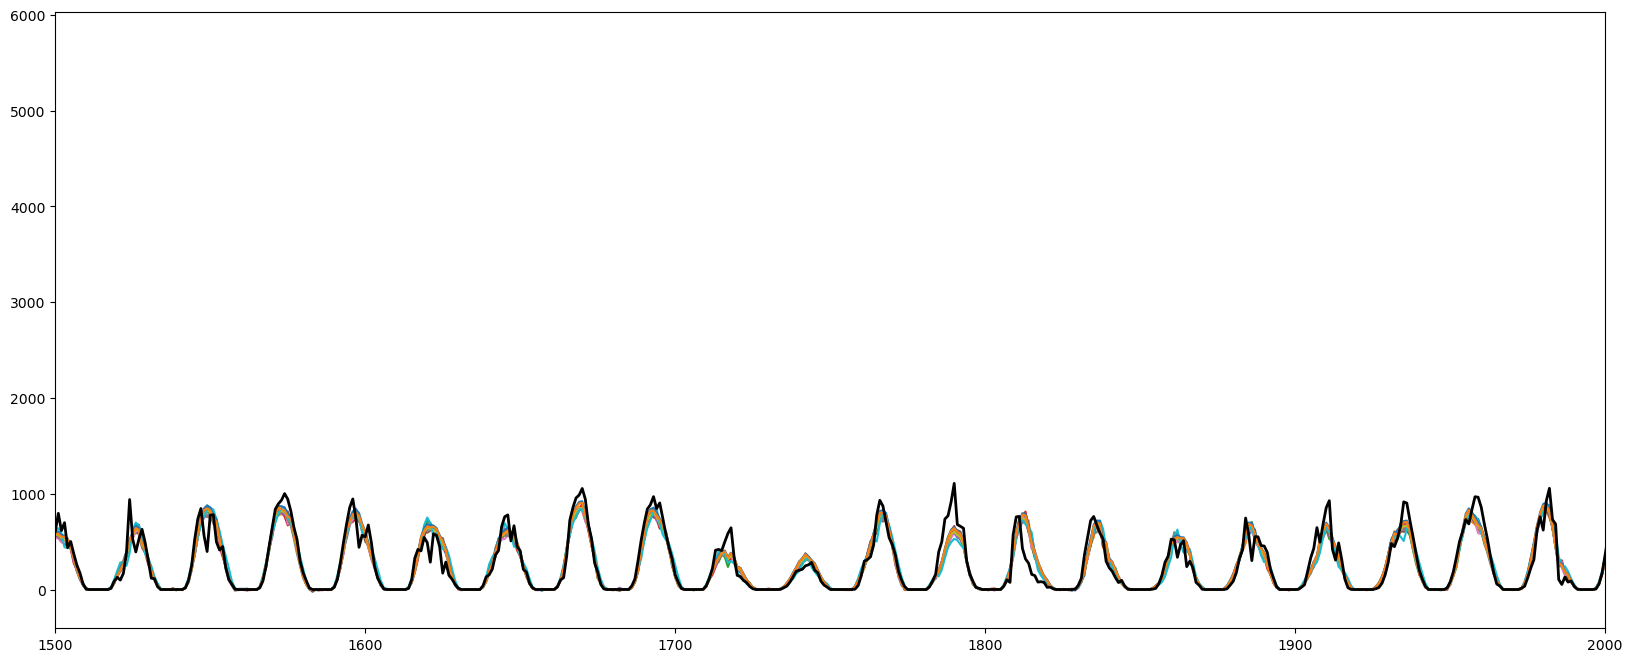

In [33]:
# pred_only_pred = predictions.iloc[:,-1:]
pred_only_pred = predictions.iloc[:,-12:]
plt.figure(figsize=(20,8))
plt.xlim(1500,2000)
#plt.ylim(-20,100)
plt.plot(pred_only_pred);
plt.plot(y_test,color='black',linewidth=2);

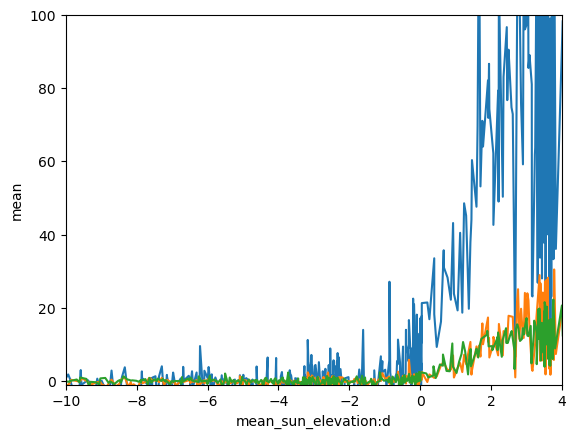

In [15]:
predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

Text(0.5, 1.0, 'Building c')

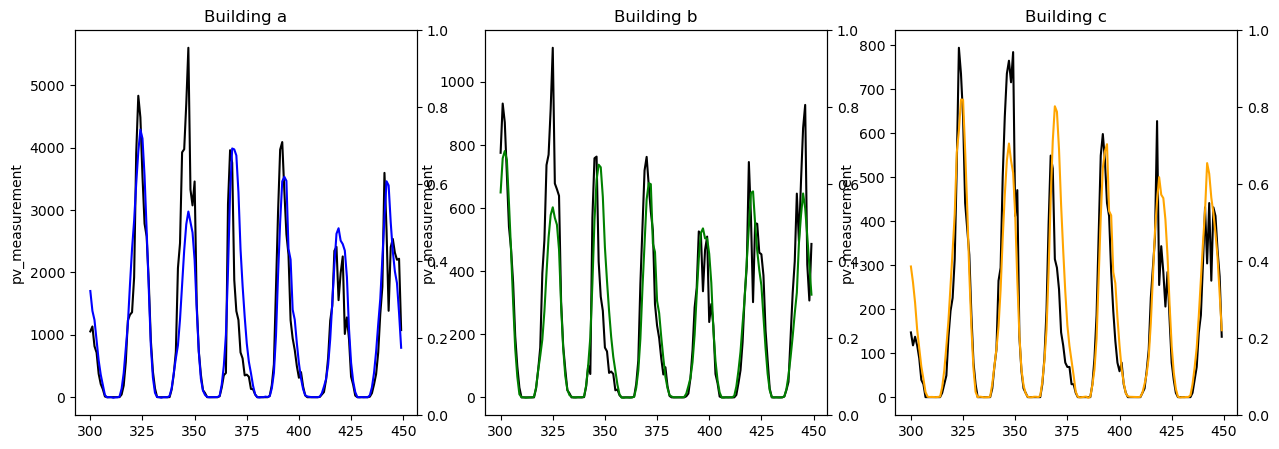

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 300
end_idx = start_idx + 150

x = predictions.index[start_idx:end_idx]

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=x, y='mean', ax=axs[0],color='blue')
ax0_twin = axs[0].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax0_twin,color='grey')


sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=x, y='mean', ax=axs[1],color='green')
ax1_twin = axs[1].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax1_twin,color='grey')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=x, y='mean', ax=axs[2],color='orange')
ax2_twin = axs[2].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax2_twin,color='grey')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

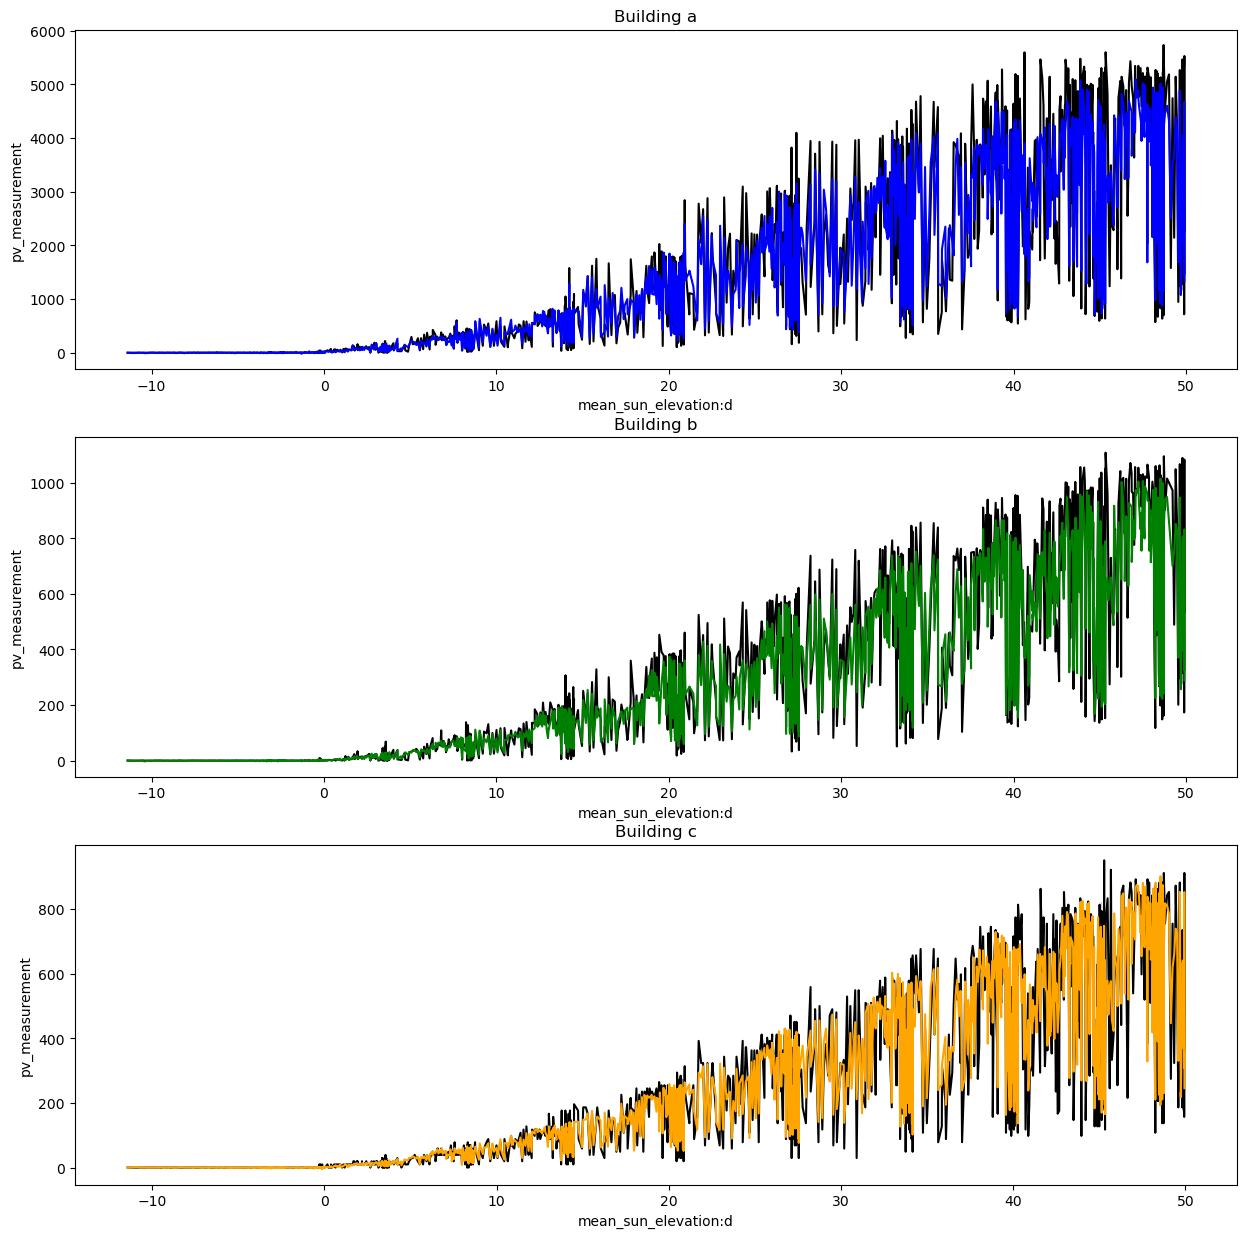

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

start_idx = 0
end_idx = 10000#start_idx + 150

feature_name = 'mean_sun_elevation:d'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

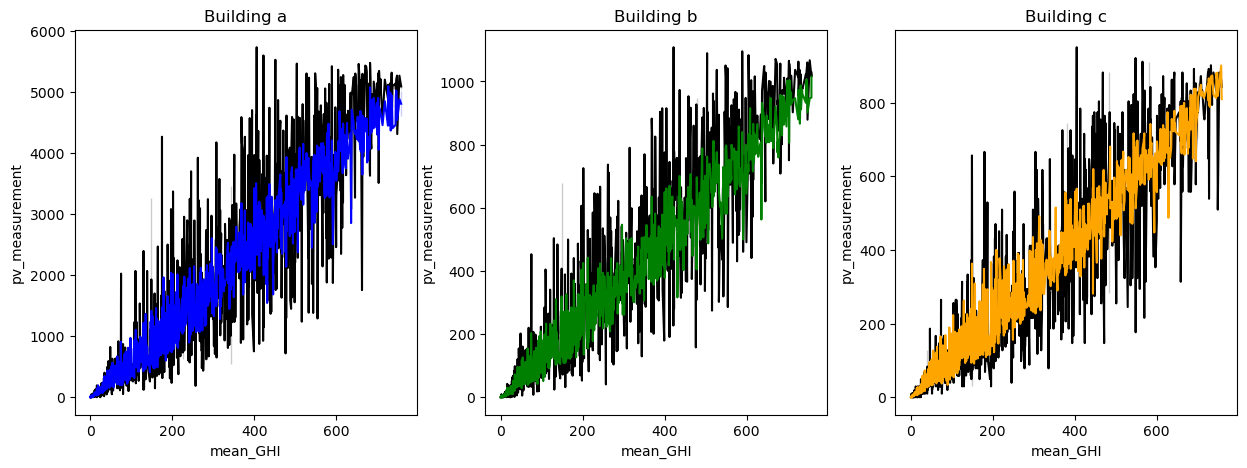

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 100
end_idx = 100000#start_idx + 150

feature_name = 'mean_GHI'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

In [19]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_date_calc,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,mean_effective_cloud_cover:p_-1h,mean_effective_cloud_cover:p_1h,mean_cloud_base_agl:m_-1h,mean_cloud_base_agl:m_1h,pv_measurement,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,Everything_0,Everything_1,Everything_2,Everything_3,mean
0,a,2021-05-01 00:00:00,0,0.0,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.750,1.28800,2263.399902,0.000000,0.000000,383.899994,0.00,272.850006,0.000000,0.000000,0.000,0.000000,80.099998,0.00,1.0,1016.575012,0.0,0.0,1003.450012,1009.724976,0.0,0.0,86.250000,1016.025024,15.557000,-10.45100,0.05,274.100006,80.175003,16891.125000,1.900,1.850,0.400,0.0,NaT,0.000000,1.359342,0.000000,163.937500,0.000000,0.977416,0.209815,0.000000,1.000000,189.842712,206.237961,81.43250,0.000000,0.000000,0.000000,0.000000,92.400002,73.224998,388.250000,448.549988,0.00,1.339009,1.574010,-3.945409,-0.063974,0.033286,0.365537,0.030146,-0.041379,2.171025,-7.779046,0.786840,-0.143654,-0.472801
1,a,2021-05-01 01:00:00,0,0.0,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.600,1.28750,1671.375000,0.000000,0.000000,388.250000,0.00,272.549988,0.000000,0.000000,0.000,0.000000,92.400002,0.00,1.0,1016.825012,0.0,0.0,1003.599976,1009.900024,0.0,0.0,85.599998,1016.200012,30.024000,-7.85575,0.10,273.924988,92.425003,17319.949219,1.625,1.600,0.300,0.0,NaT,0.000000,1.385789,0.000000,139.107513,0.000000,0.982041,0.183787,0.258819,0.965926,189.842712,206.237961,87.65875,0.000000,0.000000,0.000000,0.000000,98.125000,80.099998,347.475006,383.899994,0.00,-8.489839,4.471349,6.101910,30.544830,0.153468,-3.564781,-1.579268,1.149747,-2.384826,6.875776,-3.919289,1.902829,2.605159
2,a,2021-05-01 02:00:00,0,0.0,2021-05-01 02:00:00,2021-05-01,2021-05,5,2,4.650,1.28575,1051.675049,0.000000,0.000000,347.475006,0.00,272.649994,0.000000,0.000000,0.000,0.000000,98.125000,0.00,1.0,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,86.800003,1016.200012,44.045750,-3.82025,0.10,273.799988,98.125000,16589.625000,1.675,1.600,0.425,0.0,NaT,0.000000,1.311341,0.000000,145.372498,0.000000,0.966227,0.256470,0.500000,0.866025,189.842712,206.237961,92.87750,4.125000,0.000000,1129.012451,0.000000,98.125000,92.400002,323.350006,388.250000,0.00,-4.254780,-8.852324,-0.341608,-4.424601,1.089323,-0.474493,-9.012270,1.944267,0.238961,1.083758,-1.260887,-2.371939,-2.219716
3,a,2021-05-01 03:00:00,0,0.0,2021-05-01 03:00:00,2021-05-01,2021-05,5,3,4.750,1.28475,1624.300049,9835.325195,11.400000,323.350006,0.00,272.950012,3.975000,7132.049805,0.150,282.500000,98.125000,0.75,0.5,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,88.349998,1016.200012,57.613750,1.37325,0.20,273.700012,98.125000,14928.175781,1.525,1.450,0.400,0.0,NaT,4.125000,1.300201,1129.012451,134.707504,11.096075,0.963420,0.267251,0.707107,0.707107,189.842712,206.237961,96.85250,23.049999,0.000000,6308

In [20]:

predictions['lin_reg'] = 0



for build_id in predictions['building_id'].unique():
    linreg = LinearRegression(fit_intercept=False)

    X_lin = predictions[(predictions['building_id']==build_id) & (predictions['pv_measurement'] > 0)][['mean_GHI']].copy()
    y_lin = predictions[(predictions['building_id']==build_id) & (predictions['pv_measurement'] > 0)]['mean'].copy()

    linreg.fit(X_lin, y_lin)

    # Make predictions
    predictions.loc[predictions['building_id']==build_id,'lin_reg'] = linreg.predict(predictions[predictions['building_id']==build_id][['mean_GHI']])



In [21]:
predictions['prediction_xtreme'] = predictions['mean'] + (predictions['mean'] - predictions['lin_reg'])*0.2

In [22]:

#predictions['prediction_xtreme'] = predictions['mean'] + (predictions['mean'] - predictions['lin_reg'])*0.2
predictions.loc[predictions['building_id']=='a','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='a']['mean'] - predictions[predictions['building_id']=='a']['lin_reg']>0,
    predictions[predictions['building_id']=='a']['mean']*1.05,
    predictions[predictions['building_id']=='a']['mean']*1.01
    )

predictions.loc[predictions['building_id']=='b','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='b']['mean'] - predictions[predictions['building_id']=='b']['lin_reg']>0,
    predictions[predictions['building_id']=='b']['mean']*1.08,
    predictions[predictions['building_id']=='b']['mean']*1.06
    )
predictions.loc[predictions['building_id']=='c','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='c']['mean'] - predictions[predictions['building_id']=='c']['lin_reg']>0,
    predictions[predictions['building_id']=='c']['mean']*1.02,
    predictions[predictions['building_id']=='c']['mean']*0.98
    )

predictions['prediction_xtreme_2'] = np.where(
    predictions['mean'] - predictions['lin_reg']>0,
    1.06*predictions['mean'],
    1.02*predictions['mean']
    )


mae_xtreme_2 = mean_absolute_error(predictions['pv_measurement'], predictions['prediction_xtreme_2'])
mae_xtreme = mean_absolute_error(predictions['pv_measurement'], predictions['prediction_xtreme'])
mae = mean_absolute_error(predictions['pv_measurement'], predictions['mean'])

print(f'MAE: {mae}')
print(f'MAE Xtreme: {mae_xtreme}')
print(f'MAE Xtreme 2: {mae_xtreme_2}')

MAE: 144.07291038529857
MAE Xtreme: 140.96154531288465
MAE Xtreme 2: 141.42617064069586


Text(0.5, 1.0, 'Building c')

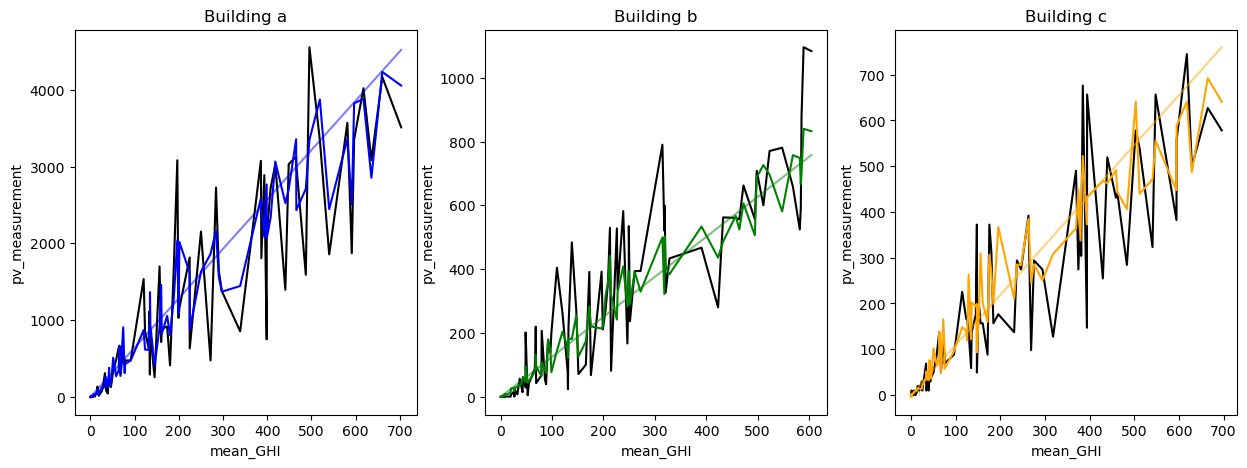

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 1100
end_idx = start_idx+100#start_idx + 150

feature_name = 'mean_GHI'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[0],color='blue',alpha=0.5)

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[1],color='green',alpha=0.5)

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[2],color='orange',alpha=0.5)

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

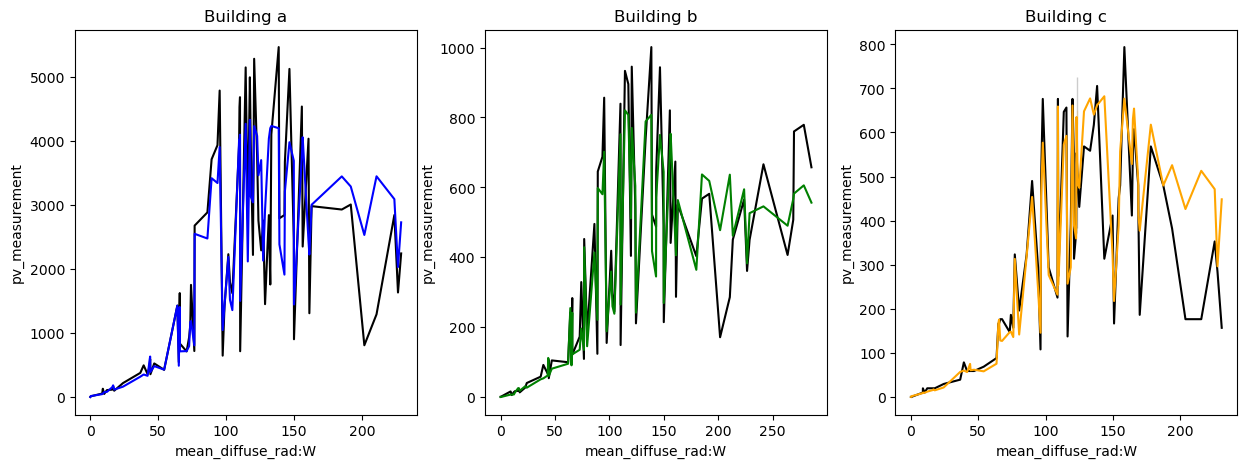

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 100
end_idx = 200#start_idx + 150

feature_name = 'mean_diffuse_rad:W'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

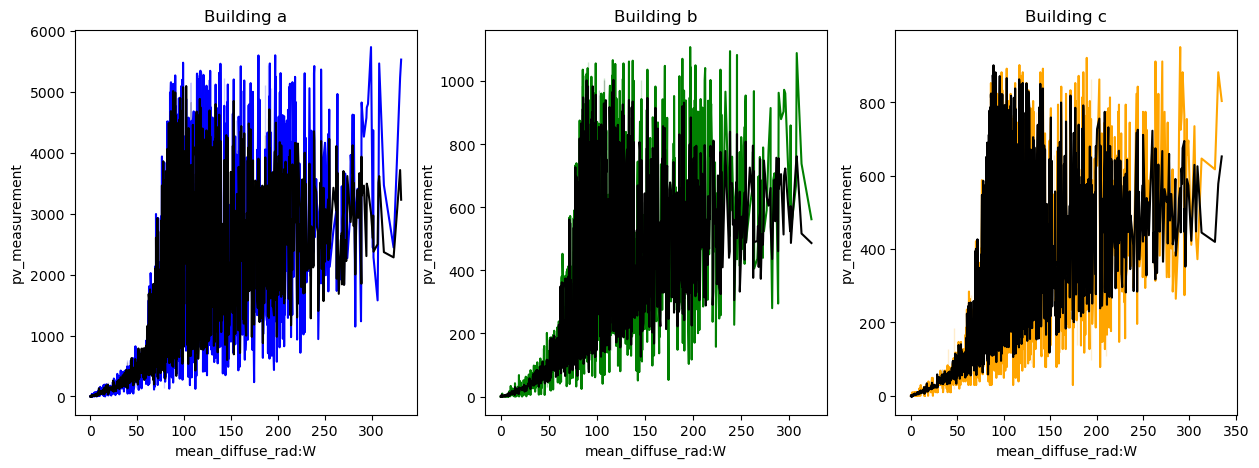

In [25]:
val_X, val_y = m_wrap.get_val(aggregated=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 0
end_idx = 10000#start_idx + 150

feature_name = 'mean_diffuse_rad:W'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='blue')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='black')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='green')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='black')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='orange')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='black')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

In [26]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [27]:
predictions['mean'].to_csv('catBoost_ensemble_12.csv', index=True)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions